In [2]:
import os
import torch
import slayerSNN as snn
from spikefi.models import DeadNeuron, ParametricNeuron, SaturatedSynapse, BitflippedSynapse
from spikefi.fault import FaultSite, Fault
from spikefi.core import Campaign
from spikefi import visual
import demo as cs
from demo import shape_in, test_loader

# Initialization
fnetname = cs.get_fnetname(trial='2')
net: cs.Network = torch.load(os.path.join(cs.OUT_DIR, cs.CASE_STUDY, fnetname))
net.eval()

LeNetNetwork(
  (slayer): spikeLayer()
  (SC1): _convLayer(2, 6, kernel_size=(7, 7, 1), stride=(1, 1, 1), bias=False)
  (SC2): _convLayer(6, 16, kernel_size=(5, 5, 1), stride=(1, 1, 1), bias=False)
  (SC3): _convLayer(16, 120, kernel_size=(5, 5, 1), stride=(1, 1, 1), bias=False)
  (SP1): _poolLayer(1, 1, kernel_size=(2, 2, 1), stride=(2, 2, 1), bias=False)
  (SP2): _poolLayer(1, 1, kernel_size=(2, 2, 1), stride=(2, 2, 1), bias=False)
  (SF1): _denseLayer(120, 84, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (SF2): _denseLayer(84, 10, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  (SDC): _dropoutLayer(p=0.4, inplace=False)
  (SDF): _dropoutLayer(p=0.2, inplace=False)
)

In [3]:
# ✅ Load test dataset
test_loader = cs.test_loader
print(f"Test set size: {len(test_loader.dataset)} images")

_, spikes, targets, labels = next(iter(test_loader))

print(f"Spikes shape: {spikes.shape}") # [Batch, Timesteps, Height, Width, Time bins] 
print(f"Targets shape: {targets.shape}") # (batch_size,target_prob,1, 1,)
print(f"Labels shape: {labels.shape}")# correct labels for each image in the batch

Test set size: 10000 images
Spikes shape: torch.Size([12, 2, 34, 34, 300])
Targets shape: torch.Size([12, 10, 1, 1, 1])
Labels shape: torch.Size([12])


In [17]:
import torch

# ✅ Create a small random tensor of shape [3, 3, 2] for visualization
tensor = torch.randint(0, 10, (3, 3, 2))  # Random integers for easier readability

# ✅ Method 1: Using `unsqueeze()` + `expand()` (Memory-efficient virtual expansion)
expanded_tensor_virtual = tensor.unsqueeze(0).expand(2, -1, -1, -1)

# ✅ Method 2: Using `unsqueeze()` + `repeat()` (True data duplication)
expanded_tensor_real = tensor.unsqueeze(0).repeat(2, 1, 1, 1)

# ✅ Convert tensors to lists for better display
original_data = tensor.tolist()
virtual_data = expanded_tensor_virtual.tolist()
real_data = expanded_tensor_real.tolist()

(original_data, virtual_data, real_data)
print('Original data: ',original_data)
print('virtual data: ',virtual_data)
print('real data: ',real_data)

Original data:  [[[4, 9], [5, 5], [1, 5]], [[9, 4], [6, 1], [2, 2]], [[5, 6], [2, 9], [1, 2]]]
virtual data:  [[[[4, 9], [5, 5], [1, 5]], [[9, 4], [6, 1], [2, 2]], [[5, 6], [2, 9], [1, 2]]], [[[4, 9], [5, 5], [1, 5]], [[9, 4], [6, 1], [2, 2]], [[5, 6], [2, 9], [1, 2]]]]
real data:  [[[[4, 9], [5, 5], [1, 5]], [[9, 4], [6, 1], [2, 2]], [[5, 6], [2, 9], [1, 2]]], [[[4, 9], [5, 5], [1, 5]], [[9, 4], [6, 1], [2, 2]], [[5, 6], [2, 9], [1, 2]]]]


In [8]:
# Testing

# ✅ Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

stats = snn.utils.stats()
spike_loss = snn.loss(cs.net_params).to(device)

for i, (_, input, target, label) in enumerate(cs.test_loader, 0):
    print(input.shape)
    input = input.to(device)
    target = target.to(device)

    output = net.forward(input)

    stats.testing.correctSamples += torch.sum(snn.predict.getClass(output) == label).data.item()
    stats.testing.numSamples += len(label)

    loss = spike_loss.numSpikes(output, target)
    stats.testing.lossSum += loss.cpu().data.item()
    stats.print(0, i)

stats.update()

Using device: cuda
torch.Size([12, 2, 34, 34, 300])

Epoch :          0(i =       0)
None
loss = 0.13792                            accuracy = 1                        
torch.Size([12, 2, 34, 34, 300])

Epoch :          0(i =       1)
None
loss = 0.55062                            accuracy = 0.91667                  
torch.Size([12, 2, 34, 34, 300])

Epoch :          0(i =       2)
None
loss = 0.39315                            accuracy = 0.94444                  
torch.Size([12, 2, 34, 34, 300])

Epoch :          0(i =       3)
None
loss = 0.32656                            accuracy = 0.95833                  
torch.Size([12, 2, 34, 34, 300])

Epoch :          0(i =       4)
None
loss = 0.27369                            accuracy = 0.96667                  
torch.Size([12, 2, 34, 34, 300])

Epoch :          0(i =       5)
None
loss = 0.241                              accuracy = 0.97222                  
torch.Size([12, 2, 34, 34, 300])

Epoch :          0(i =       6)
None
loss = 0.2

KeyboardInterrupt: 

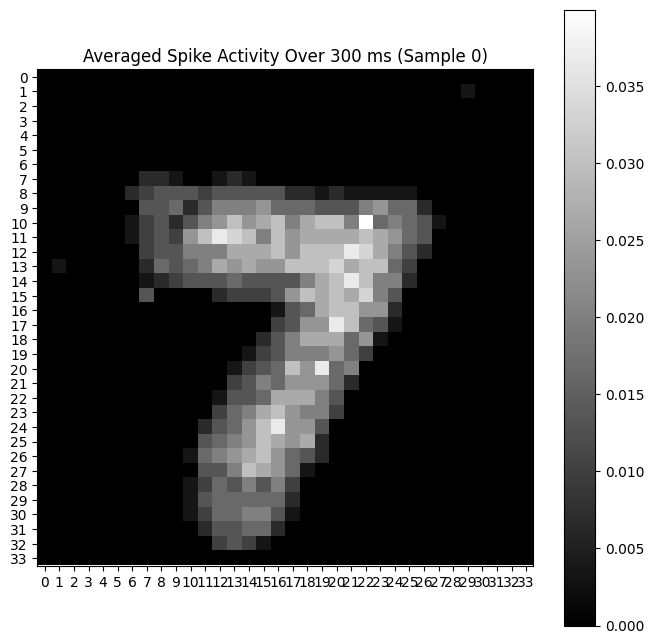

Label:  tensor(7)


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Load one batch from test_loader
_, spikes, targets, labels = next(iter(cs.test_loader))

# ✅ Select one sample (first image in batch)
sample_idx = 0  # Choose the first image in batch
timestep = 0  # Choose first timestep (since all timesteps will be summed, any timestep index is fine)

# ✅ Compute the average spike activity over all 300 time bins
spike_image_avg = spikes[sample_idx, timestep, :, :, :].sum(dim=-1).cpu().numpy() / 300  # Average over time bins

# ✅ Plot the averaged spike image with values
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(spike_image_avg, cmap="gray", interpolation="nearest")  # Display the averaged matrix

# ✅ Add colorbar to visualize intensity
plt.colorbar(im, ax=ax)

# ✅ Set grid ticks
ax.set_xticks(np.arange(spike_image_avg.shape[1]))
ax.set_yticks(np.arange(spike_image_avg.shape[0]))

# # ✅ Display the average values on the grid
# for i in range(spike_image_avg.shape[0]):  # Height
#     for j in range(spike_image_avg.shape[1]):  # Width
#         ax.text(j, i, f"{spike_image_avg[i, j]:.2f}", ha="center", va="center", color="red", fontsize=6)

plt.title(f"Averaged Spike Activity Over 300 ms (Sample {sample_idx})")
plt.show()
print('Label: ',labels[0])



tensor([0., 1.])


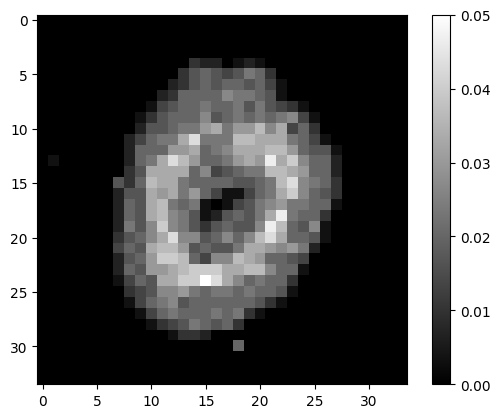

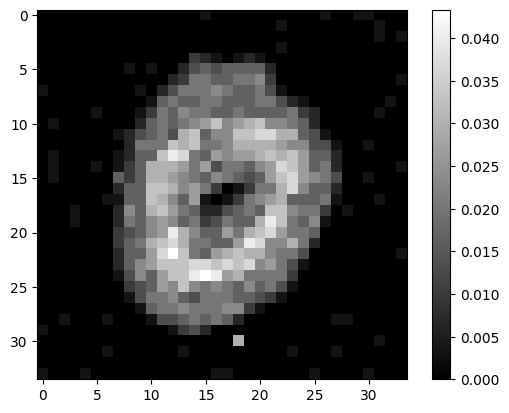

In [39]:
# ✅ Load one batch from test_loader
_, spikes, targets, labels = next(iter(cs.test_loader))

# ✅ Select one sample (first image in batch)
sample_idx = 0  # Choose the first image in batch
timestep = 0  # Choose first timestep

print(spikes.unique())
# ✅ Extract a single time slice
spike_image = spikes[3, timestep, :, :, :].sum(dim=-1).cpu().numpy() / 300
spike_image1 = spikes[3, 1, :, :, :].sum(dim=-1).cpu().numpy() / 300

# Likely two images must have been taken during 1 msec, and repated for 300 msec

# ✅ Plot the image
plt.imshow(spike_image, cmap="gray")
plt.colorbar()
plt.show()

plt.imshow(spike_image1, cmap="gray")
plt.colorbar()
plt.show()



In [ ]:
cmpn = Campaign(net, shape_in, net.slayer)

fx = Fault(DeadNeuron(), FaultSite('SF2'))
fy = Fault(SaturatedSynapse(10), FaultSite('SF1'))
fz = Fault(ParametricNeuron('theta', 0.5))

cmpn.inject([fx])
cmpn.then_inject([fy, fz])

# Run
cmpn.run(test_loader)

for perf in cmpn.performance:
    print(perf.testing.maxAccuracy * 100.0)

# Save & Visualize
cmpn.save()

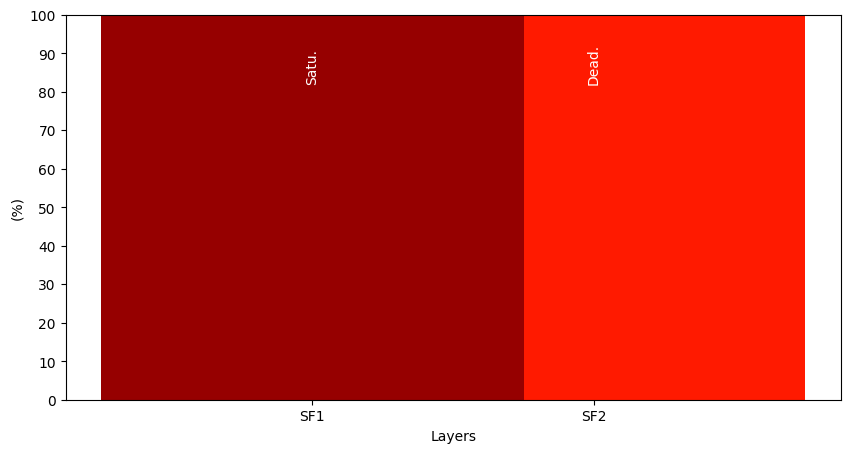

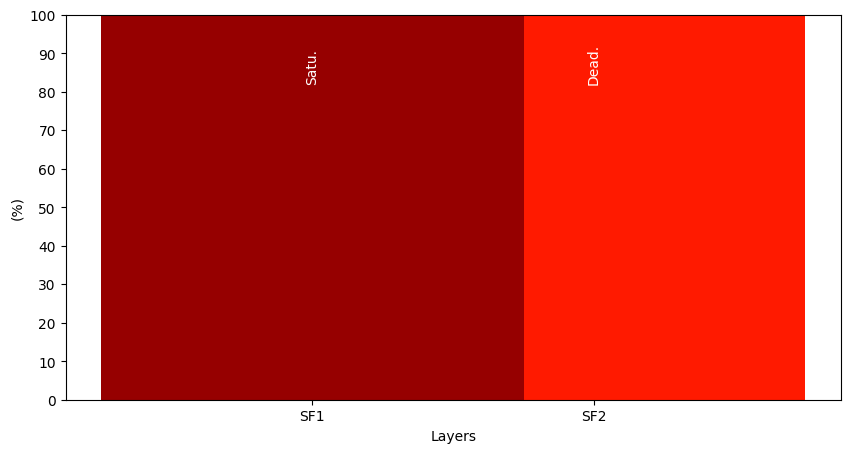

In [ ]:
visual.bar([cmpn.export()]) 

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

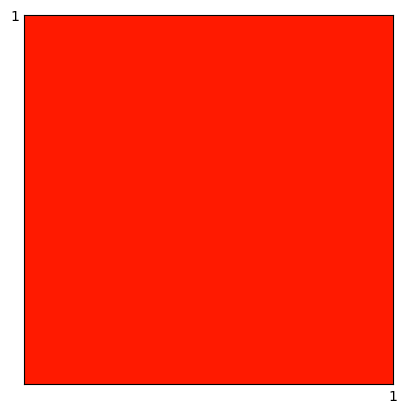

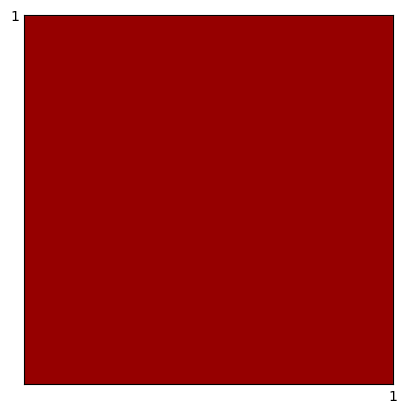

In [13]:
visual.heat([cmpn.export()], preserve_dim=True, format='png')

In [ ]:
# Reset and run new campaign layer-wise
cmpn.eject()

layer = getattr(net, 'SF2')
wmin = layer.weight.min().item()
wmax = layer.weight.max().item()

cmpn.inject_complete(BitflippedSynapse(7, wmin, wmax, torch.uint8), ['SF2'])

cmpn.run(test_loader)

visual.heat([cmpn.export()])


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    1/834  |   0.00 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    1/834  |      1 sec |   0.06 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    2/834  |      2 sec |   0.16 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    3/834  |      3 sec |   0.26 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    4/834  |      4 sec |   0.37 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    4/834  |      5 sec |   0.46 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|    5/834  

KeyboardInterrupt: 


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   88/834  |    107 sec |  10.54 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   88/834  |    108 sec |  10.54 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   88/834  |    109 sec |  10.54 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   88/834  |    110 sec |  10.54 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   88/834  |    111 sec |  10.54 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |
|   88/834  |    112 sec |  10.54 % |
+-----------+------------+----------+


+-----------+------------+----------+
|  Batch #  | Total time | Progress |

In [2]:
import os

# get the current working directory
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)

/shares/bulk/vgandham/SpikeFI/demo
